In [1]:
import os

import rasterio
from rasterio.plot import reshape_as_image
import rasterio.mask
from rasterio.features import rasterize
from rasterio.features import geometry_mask
from rasterio import features

import pandas as pd
import geopandas as gpd
from shapely.geometry import mapping, Point, Polygon, shape
from shapely.ops import cascaded_union

import numpy as np
import cv2
import matplotlib.pyplot as plt

from skimage import morphology, measure

In [2]:
raster_path = "/Users/karan.sah/Downloads/Archive/TILE__0_0.tif"
shape_path = "/Users/karan.sah/Downloads/Archive/dfc.shp"
output_path = "/Users/karan.sah/Downloads/results/"

In [3]:
gdf = gpd.read_file(shape_path)

# Get the geometry of the shapefile
geometry = gdf.geometry.iloc[0]

# Create a raster image covering the extent of the geometry
raster_shape = (1000, 1000)
transform = rasterio.transform.from_bounds(*gdf.total_bounds, *raster_shape)
raster = rasterio.open(output_path + 'raster.tif', 
                       'w', 
                       driver='GTiff', 
                       width=raster_shape[1], 
                       height=raster_shape[0],
                       count=1, 
                       dtype=rasterio.uint8, 
                       crs=gdf.crs, 
                       transform=transform
                      )

# Create a binary mask of the edges of the shapefile
lines = gdf.boundary.to_crs(raster.crs)
mask = geometry_mask(geometries=lines.geometry, 
                     out_shape=raster_shape, 
                     all_touched=True,
                     transform=raster.transform, 
                     invert=True
                    )

# Write the mask to the raster file
raster.write(mask.astype(rasterio.uint8), indexes=1)
raster.close()

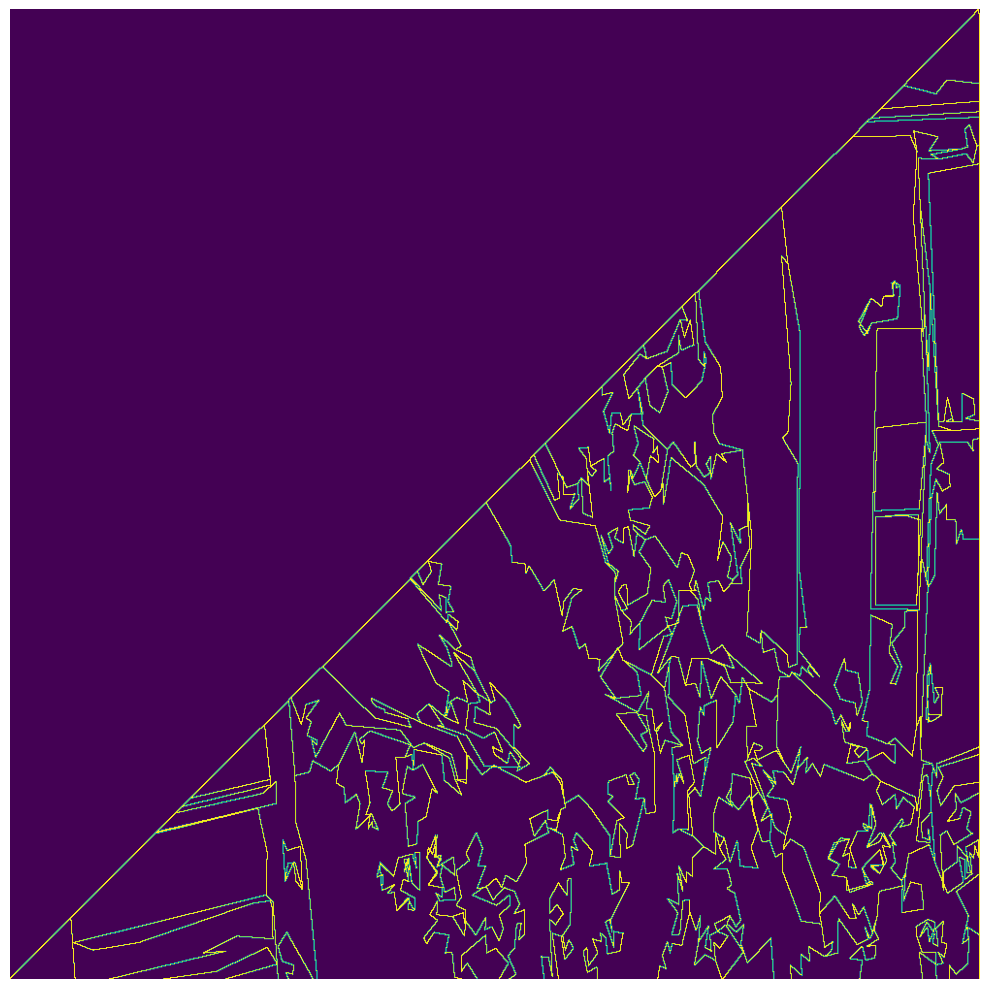

In [4]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(mask)
ax.set_axis_off()
plt.tight_layout()
plt.show()

In [5]:
from skimage import measure
from skimage.color import label2rgb
from skimage.io import imread

In [6]:
binary_mask = imread(output_path + 'raster.tif')

In [7]:
inverted_mask = 1 - binary_mask

In [8]:
labels = measure.label(inverted_mask,
                      connectivity=1
                      )

In [9]:
colors = label2rgb(labels)

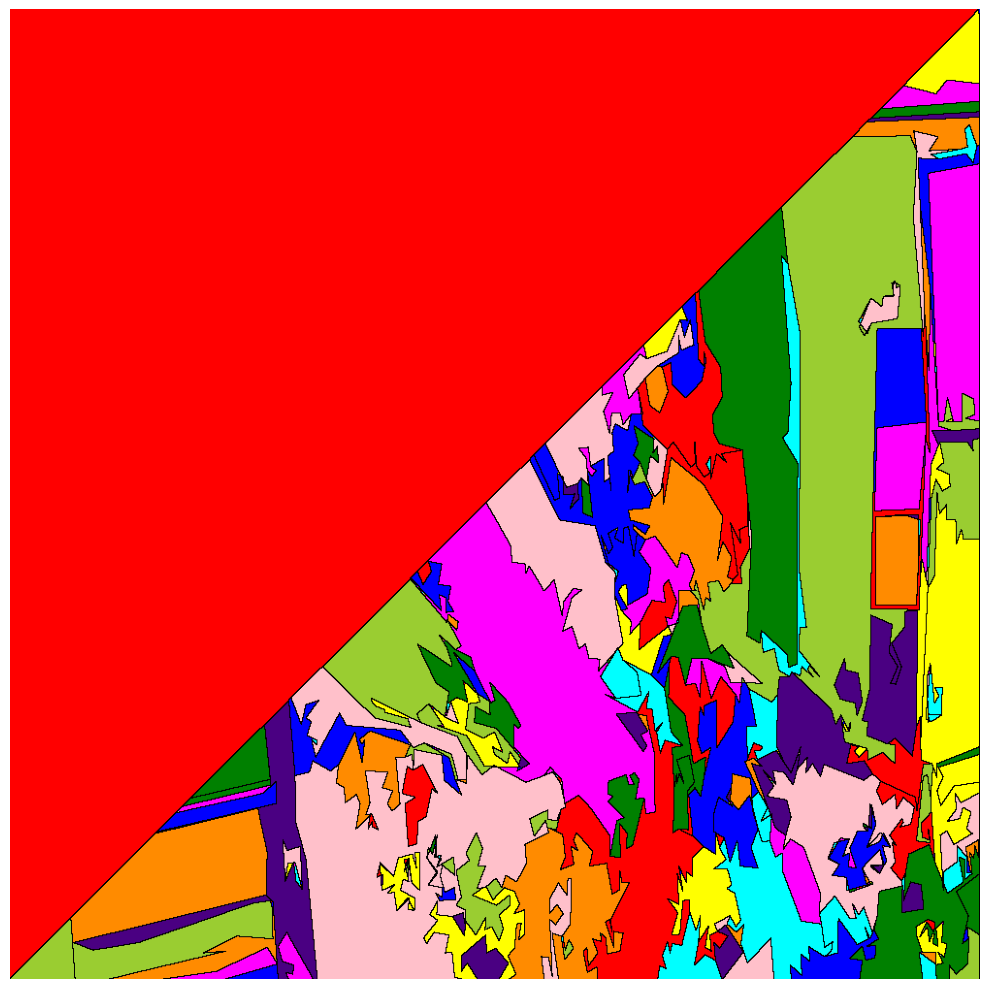

In [10]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(colors)
ax.set_axis_off()
plt.tight_layout()
plt.show()

In [11]:
np.unique(labels)

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [12]:
print(len(gdf['geometry'].values))

104


In [13]:
print(gdf.shape[0])

104


In [14]:
def get_four_neighbors(arr, i, j):
    neighbors = []
    width, height = arr.shape 
    val = arr[i,j]
    
    if (i-1 > 0):
        neighbors.append(arr[i-1, j])
        
    if (j+1 < height):
        neighbors.append(arr[i, j+1])
        
    if (i+1 < width):
        neighbors.append(arr[i+1, j])
        
    if (j-1 > 0):
        neighbors.append(arr[i, j-1])
    neighbors = [x for x in neighbors if x!=val]
    
    return neighbors

In [15]:
def most_common(lst):
    return max(set(lst), key=lst.count)

In [16]:
labeled = morphology.label(labels)

In [17]:
print(type(labeled))

<class 'numpy.ndarray'>


In [18]:
# Iterate over each labeled region

for region in measure.regionprops(labeled):
    # Check if the region has fewer than 5 pixels
    if region.area < 5:
        coords = region.coords
        for x,y in coords:
            neighbours = get_four_neighbors(labeled, x, y)
            labeled[x,y]=most_common(neighbours)


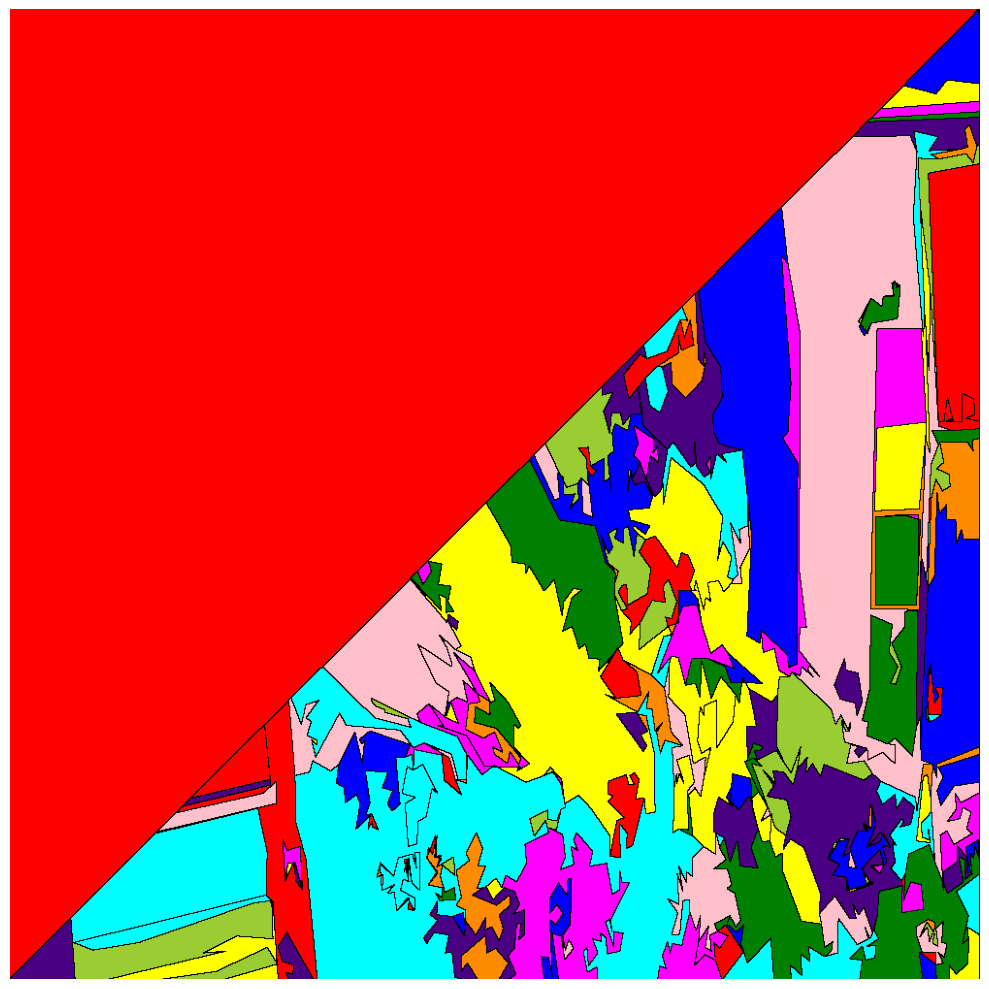

In [19]:
colors = label2rgb(labeled)
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(colors)
ax.set_axis_off()
plt.tight_layout()
plt.show()

In [20]:
np.unique(labeled)

array([  0,   1,   3,   4,   5,   6,   7,   8,   9,  10,  12,  14,  15,
        17,  18,  19,  21,  22,  23,  24,  28,  29,  30,  31,  32,  33,
        34,  36,  37,  38,  39,  40,  42,  44,  45,  46,  49,  50,  51,
        52,  53,  54,  56,  57,  58,  59,  60,  61,  62,  65,  66,  72,
        73,  74,  76,  77,  78,  79,  80,  81,  82,  84,  88,  90,  91,
        92,  93,  98,  99, 100, 101, 103, 107, 113, 115, 116, 117, 119,
       122, 125, 126, 128, 129, 131, 132, 134, 136, 138, 139, 145, 146,
       148, 149, 152, 153, 155, 158, 160, 161, 162, 163, 166, 168, 169,
       170, 173, 176, 177, 178, 181, 183, 185, 187, 188, 190, 191, 193,
       195, 199, 200, 206, 212, 213, 215, 216, 217, 219, 220, 221, 223,
       224, 225, 227, 230, 231, 232, 235, 237, 241, 242, 243, 244, 246,
       248, 249, 251, 252, 256, 257, 258, 260, 261, 262, 264, 267, 268,
       269, 270, 271, 273, 274, 275, 277, 278, 279, 285, 288, 289, 293,
       294, 300, 301, 302, 303, 306, 307, 308, 311, 315, 316, 31

In [21]:
def generate_polygons_from_label_tiles(label_tile, transform, crs):
    
    label_indexes = [i for i in np.unique(label_tile) if i>0]
    gdf_list = []
    
    for label_idx in label_indexes:
        mask = label_tile == label_idx
        shapes = features.shapes(label_tile, mask=mask, transform=transform)
        geometry, labels = [], []
        
        for i, (shapedict, value) in enumerate(shapes):
            geometry.append(shape(shapedict))
            labels.append(value)
            
        gdf = gpd.GeoDataFrame(
            {'geometry': geometry, 'label': labels},
            crs=crs
        )
        gdf_list.append(gdf)
        
    return pd.concat(gdf_list)

In [22]:
print(type(labeled))

<class 'numpy.ndarray'>


In [23]:
labeled = labeled.astype(rasterio.int16)

In [24]:
print(type(labeled[0][0]))

<class 'numpy.int16'>


In [25]:
generated_df = generate_polygons_from_label_tiles(labeled, raster.transform, raster.crs)

In [26]:
generated_df

,geometry,label
0,"POLYGON ((357475.000 5842210.000, 357475.000 5...",1.0
0,"POLYGON ((358411.183 5842208.960, 358412.122 5...",3.0
0,"POLYGON ((358382.074 5842171.520, 358389.586 5...",4.0
0,"POLYGON ((358404.610 5842160.080, 358413.061 5...",5.0
0,"POLYGON ((358411.183 5842154.880, 358413.061 5...",6.0
...,...,...
0,"POLYGON ((358015.864 5841709.760, 358016.803 5...",370.0
0,"POLYGON ((357722.896 5841706.640, 357723.835 5...",374.0
0,"POLYGON ((358357.660 5841704.040, 358357.660 5...",377.0
0,"POLYGON ((358355.782 5841703.520, 358355.782 5...",378.0


In [27]:
generated_df.to_file(output_path + 'gdf_modified_label.shp')  

In [28]:
generated_df.is_valid.value_counts()

True    213
dtype: int64